In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import stefcal
import simulation 
import pointSourceGenerator as psg
import numpy.fft as fft
import scipy.signal as signal
from joblib import Parallel, delayed
import multiprocessing
import copy
n_cpu=multiprocessing.cpu_count()
import cosmology
import delayGridding as dG
littleh=0.68
c=3e8
pi=np.pi

0.048252


In [2]:
def xyz2nsew(lat,inverse=False):
    output=np.array([[0.,1.,0.],
                     [-np.sin(lat),0.,np.cos(lat)],
                     [np.cos(lat),0.,np.sin(lat)]])
    if(inverse):
        output=np.linalg.invert(output)
    return output

def invRotLat(positions,lat):
    rMat=xyz2nsew(lat)
    output=np.zeros_like(positions)
    for i in range(positions.shape[0]):
        output[i,:]=np.dot(rMat,positions[i,:])
    return output

In [3]:
latitude=np.radians(-30.)
antLocs=np.loadtxt('MWA_128T_antenna_locations_MNRAS_2012_Beardsley_et_al.txt',skiprows=6)[:,:3]
#antLocs=np.loadtxt('LOFAR_HBA_antenna_locations.txt')
#antLocs=np.loadtxt('/Users/aaronew/Dropbox (MIT)/Science/data/array_layouts/LOFAR_HBA_antenna_locations.txt')
#nant=len(antLocs/2)
#antLocs=antLocs[:nant/2,:]
antLocs=invRotLat(antLocs,latitude)[:,:2]
nAnt=len(antLocs)
band=20e6
df=100e3
cFreq=150e6
dAnt=4.
sAnt=0.45*c/(cFreq*dAnt)
testArray=simulation.DriftArray(antLocs[:,:2],dAnt=dAnt,b=band,df=df,f0=cFreq)
#testArray_noPara=simulation.DriftArray(antLocs[:,:2],dAnt=dAnt,b=band,df=df)
testArrayModel=simulation.DriftArray(antLocs[:,:2],dAnt=dAnt,b=band,df=df,f0=cFreq)

In [4]:
#generate a source catalog from 0.5 Jy min flux
nsrc=120000
'''
srcList=simulation.drawRandomSources(.01)
beamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)
#arrange by column
apparentFlux=srcList[:,2]*beamVals
srcList=srcList[np.argsort(apparentFlux),:][-nsrc:,:][::-1,:]
del apparentFlux
cutoff=0.035
maxFlux=srcList[:,2].max()
srcList=np.vstack([srcList,[0.,0.,maxFlux*3.,-0.5]])
brightSources=srcList[srcList[:,2]>cutoff,:]
print srcList[:,2].min()
print srcList[:,2].max()
'''

'\nsrcList=simulation.drawRandomSources(.01)\nbeamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)\n#arrange by column\napparentFlux=srcList[:,2]*beamVals\nsrcList=srcList[np.argsort(apparentFlux),:][-nsrc:,:][::-1,:]\ndel apparentFlux\ncutoff=0.035\nmaxFlux=srcList[:,2].max()\nsrcList=np.vstack([srcList,[0.,0.,maxFlux*3.,-0.5]])\nbrightSources=srcList[srcList[:,2]>cutoff,:]\nprint srcList[:,2].min()\nprint srcList[:,2].max()\n'

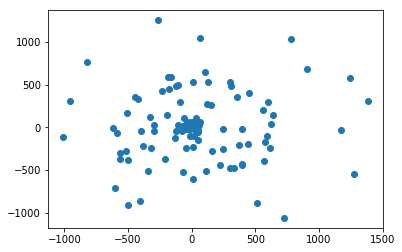

In [5]:
plt.scatter(antLocs[:,0]-np.median(antLocs[:,0]),antLocs[:,1]-np.median(antLocs[:,1]))

In [6]:
#generate a source catalog from 0.5 Jy min flux
nsrc=120000
srcList=psg.drawRandomSources(.1)
#arrange by column
#apparentFlux=srcList[:,2]*beamVals
#srcList=srcList[np.argsort(apparentFlux),:][-nsrc:,:][::-1,:]
#del apparentFlux
cutoff=1
srcList=np.load('mwa128_wSim_sources.npy')
beamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)
maxInd=np.where((srcList[:,2]*beamVals).max()==srcList[:,2]*beamVals)
srcList[maxInd,1]=30.*np.pi/180.
brightSources=srcList[srcList[:,2]>cutoff,:]
#print srcList[:,2].min()
#print srcList[:,2].max()

number of sources=108539


(108244,)


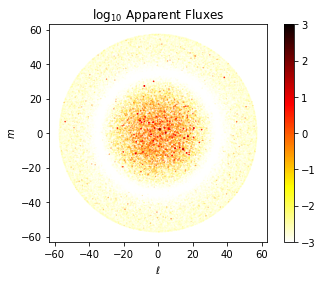

In [49]:
beamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)
srcListSorted=np.zeros((srcList.shape[0],),dtype=[('ell','float64'),('m','float64'),('s150','float64'),('alpha','float64')])
print srcListSorted.shape
srcListSorted['ell']=srcList[:,0]
srcListSorted['m']=srcList[:,1]
srcListSorted['s150']=beamVals*srcList[:,2]
srcListSorted['alpha']=srcList[:,3]
srcListSorted.sort(order='s150')

fig=plt.figure()
ax=fig.add_subplot(111,axisbg='w')
maxFlux=(srcListSorted['s150']).max()
scp=ax.scatter(180./np.pi*srcListSorted['ell'],
            180./np.pi*srcListSorted['m'],
            s=srcListSorted['s150']/10,
            c=np.log10(srcListSorted['s150']),cmap='hot_r',vmin=-3,vmax=3)
ax.set_aspect('equal')
plt.colorbar(scp)
plt.title('$\\log_{10}$ Apparent Fluxes')
plt.xlabel('$\\ell$')
plt.ylabel('$m$')
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/apparentFluxes_brightOffCenter.png',bbox_inches='tight')

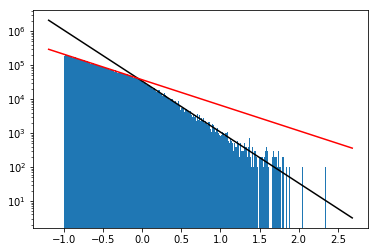

In [8]:
dlogsbin=0.01
binEdges=np.log10(.05)+np.arange(10,400)*dlogsbin
binCenters=binEdges[:-1]+dlogsbin/2
counts,_=np.histogram(np.log10(srcList[:,2]),binEdges)
plt.bar(binCenters,counts/dlogsbin,width=dlogsbin)
ys1=np.log(10.)*2*pi*3200*10**(-1.5*binCenters)*.88**2.5
ys2=np.log(10.)*2*pi*3200*10**(-.75*binCenters)*.88**1.75


plt.plot(binCenters,ys1,color='k')
plt.plot(binCenters,ys2,color='r')

plt.yscale('log')

In [9]:
print len(srcList)
print len(brightSources)

108244
9621


In [10]:
testArray.setSourceList(srcList)
testArrayModel.setSourceList(brightSources)
#compute visibilities
testArray._computeVisibilities(parallel=True)
#testArray_noPara._computeVisibilities(parallel=False)
testArrayModel._computeVisibilities(parallel=True)



In [11]:
#vCube=testArray.visCube
#vCubeNP=testArray.visCube
#plt.imshow(np.log10(np.abs(1-vCube/vCubeNP)))/'
#plt.colorbar()

In [12]:
#generate some gains with a ripple that has random phases and amplitudes
refAnt=0
rScale=1e-2
rDelay=1200e-9
rAmp=rScale*np.abs(np.random.randn(len(antLocs)))
rPhase=np.random.rand(len(antLocs))
gains=np.zeros((len(testArray.fAxis),len(antLocs)),dtype=complex)
for gnum in range(gains.shape[1]):
    gains[:,gnum]=1./(1.-rAmp[gnum]*np.exp(2j*np.pi*(rDelay*testArray.fAxis+rPhase[gnum])))
gains[:,refAnt]=np.abs(gains[:,refAnt])    

In [13]:
def getCalibrationGrid(array,arrayModel,gainsTrue,gainsEstimated,flags,nCells=80):
    modelVis=copy.copy(arrayModel.visCube)
    array.applyGains(gainsTrue)
    array.correctGains(gainsEstimated)
    array.visCube-=modelVis
    #kperp,kpara,vGrid=array.getCosmologyDVisGrid()
    vC=array.visCube
    bLens=np.linalg.norm(array.separations,axis=1)
    kperp,kpara,vGrid=dG.delayTransformAndGrid(vC,bLens,array.f0,array.df,nCells,bLens.max()*array.f0/c,array.dAnt,flags)
    array.visCube+=modelVis
    array.correctGains(gainsTrue)
    array.applyGains(gainsEstimated)
    return kperp,kpara,vGrid

In [14]:
sigma_w=25.
weights=np.exp(-np.linalg.norm(testArray.separations,axis=1)**2./(2.*sigma_w**2.))
nvis=0
regFactor=1e-6
weightsMatrix=np.zeros((testArray.nAnt,testArray.nAnt),dtype=complex)
for i in range(testArray.nAnt):
    for j in range(i):
        weightsMatrix[i,j]=weights[nvis]
        weightsMatrix[j,i]=weights[nvis]
        nvis+=1
weightsMatrix[weightsMatrix<regFactor]=regFactor

In [15]:
def computeNeff(wMat):
    nEff=np.zeros(wMat.shape[0])
    for nA in range(wMat.shape[0]):
        nEff[nA]=np.abs(wMat[nA,:]).sum()/np.abs(wMat[nA,:]).max()
    return nEff

def trimNeff(wMat,threshold=2):
    wMat_c=copy.deepcopy(wMat)
    vFlags=np.empty(wMat_c.shape,dtype=bool);vFlags[:]=False
    vFlagsL=np.empty(len(wMat_c)*(len(wMat_c)-1)/2,dtype=bool);vFlagsL[:]=False
    nEff=computeNeff(wMat_c)
    nFlag=0
    nvis=0
    while(np.any(nEff<threshold)):
        for i in range(wMat_c.shape[0]):
            if(nEff[i]<threshold):
                maxInd=np.where(wMat_c[i,:]==wMat_c[i,:].max())[0][0]
                wMat_c[i,maxInd]=0.
                wMat_c[maxInd,i]=0.
                vFlags[maxInd,i]=True
                vFlags[i,maxInd]=True
                nFlag+=1        
        nEff=computeNeff(wMat_c)
    for i in range(len(vFlags)):
        for j in range(i):
            vFlagsL[nvis]=vFlags[i,j]
            nvis+=1
    antFlag=np.empty(wMat.shape[0],dtype=bool)
    antFlag[:]=False
    for i in range(wMat.shape[0]):
        antFlag[i]=np.all(wMat_c[i,:]==0)
    return nFlag,antFlag,wMat_c,vFlags,vFlagsL
                
            

In [16]:
print computeNeff(weightsMatrix)


[   4.22967165   17.27326724   19.16749394   18.99883881   16.1392516
   11.13673273   13.38221203    3.81914002    5.6236964     4.91512591
    7.07666129   16.73634138   19.12475453   19.18470443   20.32277715
    3.34994345    2.69805762    5.33363727   10.45341192   13.89980229
   19.34993167   21.11403182   20.54860653   17.60456322   20.20890756
   18.84271775   18.17037226   14.28109866   15.99232159    7.47319635
   14.24974889    4.90749906    1.36165057    1.09721654    1.08119999
    1.09704417    1.06699008    1.02621388    1.00198019    1.08658562
   10.1966892    15.86858992   18.52394396   21.0140031    20.79671515
   20.71927037   18.27770572   13.93083942    1.6931076     1.17525851
  128.            1.00580533    1.00580533    1.79208616    1.02049917
    1.03869097  128.            1.73923866    7.66142974    6.6189685
    3.86714374    5.73591411    1.30085057  128.          128.          128.
    3.77736385    6.4244786     5.75319242    2.81310039    1.00039235
  

In [17]:
nFlag,aFlag,wMat_t,flagMat,flagList=trimNeff(weightsMatrix)
print aFlag
print nFlag
print computeNeff(wMat_t)
#reassign antennas 

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
68
[   4.14672532   17.27326724   19.16749394   18.99883881   16.1392516
   11.13673273   13.38221203    3.35649008    5.61981386    4.90306071
    7.07666129   16.73634138   19.12475453   19.18470443   20.32277715
    3

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


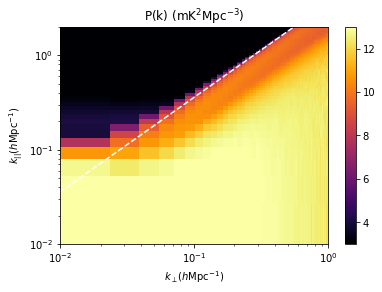

In [18]:
kperp_e,kpara_e,vGrid_true=getCalibrationGrid(testArray,testArrayModel,gains,gains,flagList)
wVal=cosmology.wedge(cosmology.f2z(cFreq))
wLine=kperp_e*wVal
kperpG,kparG=np.meshgrid(kperp_e,kpara_e)
plt.pcolor(kperpG,kparG,np.log10(vGrid_true),cmap='inferno',vmin=2,vmax=13)
#plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^{-3}$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.show()

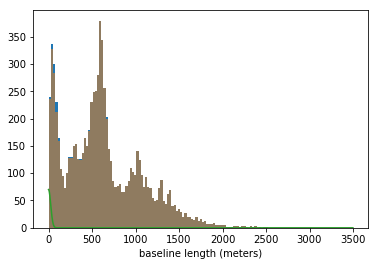

In [19]:
plt.hist(np.abs(np.linalg.norm(testArray.separations,axis=1)),bins=100,alpha=1)
plt.hist(np.abs(np.linalg.norm(testArray.separations[np.invert(flagList)],axis=1)),bins=100,alpha=.5)


x=np.arange(0,3500)
plt.plot(x,70*np.exp(-x**2/(2.*sigma_w**2.)))
plt.xlabel('baseline length (meters)')

In [20]:


def calibrateChannels(data,model,weights,parallel=False):
    output=np.ones((data.shape[0],data.shape[1]),dtype=complex)
    #output=np.array(Parallel(n_jobs=n_cpu/2)(delayed(calibrateChannelParallel)(data[i,:,:],
    #                                                          model[i,:,:],
    #                                                           output[i,:],
    #                                                          weights[i,:,:]) for i in range(data.shape[0])))
    if(parallel):
        output=Parallel(n_jobs=n_cpu/2)(delayed(stefcal.calibrate_2_basic_scaler)(data[i,:,:],
                                                                   model[i,:,:],
                                                                   output[i,:],
                                                                   np.zeros_like(output[i,:]),
                                                                   1e-10,
                                                                   weights[i,:,:],
                                                                   0,
                                                                   5,
                                                                   False) for i in range(data.shape[0]))
    else:
        output=[stefcal.calibrate_2_basic_scaler(data[i,:,:],
                                                 model[i,:,:],
                                                 output[i,:],
                                                 np.zeros_like(output[i,:]),
                                                 1e-10,
                                                 weights[i,:,:],
                                                 0,
                                                 5,
                                                 False) for i in range(data.shape[0])]
    niters=[]
    output_data=[]
    for m in range(len(output)):
        niters.append(output[m][0])
        output_data.append(output[m][1])
    
    return niters,np.array(output_data)
    
    
#def calibrate_2_basic_scaler_cycles_jit(dataMatrix,
#modelMatrix,gains,gbuffer,eps,weights,refant=0,
#n_phase_iter=5,recompute=False,ncycles=1,antFlags=None,visFlags=None):
def calibrateChannelsFlags(data,model,weights,antFlags,flags,eps=1e-10,ncycles=2,parallel=False):
    output=np.ones((data.shape[0],data.shape[1]),dtype=complex)
    #output=np.array(Parallel(n_jobs=n_cpu/2)(delayed(calibrateChannelParallel)(data[i,:,:],
    #                                                          model[i,:,:],
    #                                                           output[i,:],
    #                                                          weights[i,:,:]) for i in range(data.shape[0])))
    if(parallel):
        output=Parallel(n_jobs=n_cpu/2)(delayed(stefcal.calibrate_2_basic_scaler_cycles)(data[i,:,:],
                                                                   model[i,:,:],
                                                                   output[i,:],
                                                                   np.zeros_like(output[i,:]),
                                                                   eps,
                                                                   weights[i,:,:],
                                                                   refant=0,
                                                                   n_phase_iter=5,
                                                                   recompute=False,
                                                                   ncycles=ncycles,
                                                                   antFlags=antFlags,
                                                                   visFlags=flags) for i in range(data.shape[0]))
    else:
        output=[stefcal.calibrate_2_basic_scaler_cycles(data[i,:,:],
                                                       model[i,:,:],
                                                       output[i,:],
                                                       np.zeros_like(output[i,:]),
                                                       eps,
                                                       weights[i,:,:],
                                                       refant=0,
                                                       n_phase_iter=5,
                                                       recompute=False,
                                                       ncycles=ncycles,
                                                       antFlags=antFlags,
                                                       visFlags=flags) for i in range(data.shape[0])]
    niters=[]
    output_data=[]
    for m in range(len(output)):
        niters.append(output[m][0])
        output_data.append(output[m][1])
    
    return niters,np.array(output_data)


In [21]:
print np.sqrt(4000*2*(0.88)**(2.5)*10**0.5*np.pi*(.45*2/4)**2.)
print np.sqrt(4000*2*(0.88)**(2.5)*10**0.5*np.pi*(.45*2/35.)**2.)

54.063702939
6.17870890731


(array([  3.00000000e+00,   1.10000000e+01,   2.90000000e+01,
          1.04000000e+02,   3.94000000e+02,   1.12700000e+03,
          2.87900000e+03,   3.15700000e+03,   4.21000000e+02,
          3.00000000e+00]),
 array([-0.0034224 ,  0.26228811,  0.52799862,  0.79370913,  1.05941963,
         1.32513014,  1.59084065,  1.85655115,  2.12226166,  2.38797217,
         2.65368268]),
 <a list of 10 Patch objects>)

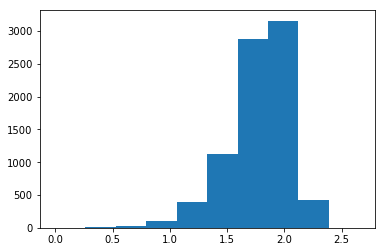

In [22]:
plt.hist(np.log10(np.abs(testArray.visCube[0,:])))

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


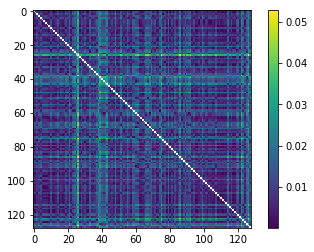

In [23]:

testArray.applyGains(gains)
dCube=testArray.getVisCubeMatrixOrder()
testArray.correctGains(gains)
mCube=testArray.getVisCubeMatrixOrder()
wCube=np.ones_like(mCube)
vF=np.empty((nAnt,nAnt),dtype=bool)
vF[:]=False
nitersPerfect,gainSolutionsPerfect=calibrateChannelsFlags(dCube,mCube,wCube,aFlag,vF,ncycles=5)
plt.imshow(np.abs(1-mCube[0,:,:]/dCube[0,:,:]),interpolation='nearest')
plt.colorbar()

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


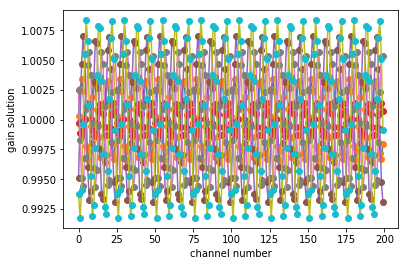

In [24]:
for i in range(5):
    plt.plot(gainSolutionsPerfect[:,i])
    plt.plot(gains[:,i],ls='none',marker='o')

#plt.yscale('log')

plt.ylabel('gain solution')
plt.xlabel('channel number')
plt.legend()
#plt.yscale('log')


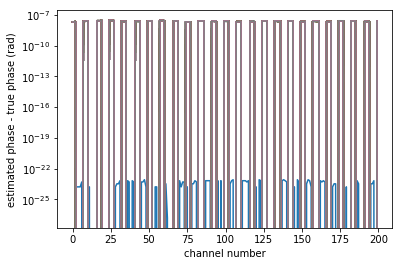

In [25]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutionsPerfect[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.yscale('log')


In [26]:
print np.array(nitersPerfect).astype(int)

[[2341    5    5    5    5]
 [2403    5    5    5    5]
 [2296    5    5    5    5]
 [2153    5    5    5    5]
 [2442    5    5    5    5]
 [2512    5    5    5    5]
 [2429    5    5    5    5]
 [2067    5    5    5    5]
 [2612    5    5    5    5]
 [2808    5    5    5    5]
 [2767    5    5    5    5]
 [1787    5    5    5    5]
 [2827    5    5    5    5]
 [2980    5    5    5    5]
 [2922    5    5    5    5]
 [2276    5    5    5    5]
 [2824    5    5    5    5]
 [2915    5    5    5    5]
 [2872    5    5    5    5]
 [2673    5    5    5    5]
 [2845    5    5    5    5]
 [3107    5    5    5    5]
 [3168    5    5    5    5]
 [2889    5    5    5    5]
 [2942    5    5    5    5]
 [3158    5    5    5    5]
 [3068    5    5    5    5]
 [2689    5    5    5    5]
 [2517    5    5    5    5]
 [2652    5    5    5    5]
 [2642    5    5    5    5]
 [2504    5    5    5    5]
 [2298    5    5    5    5]
 [2617    5    5    5    5]
 [2682    5    5    5    5]
 [2568    5    5    

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


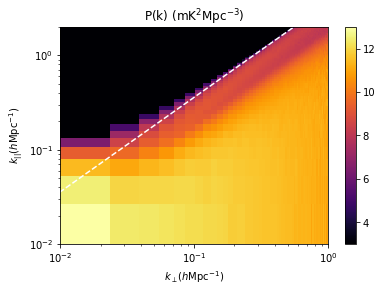

In [27]:
kperp_e,kpara_e,vGrid_true=getCalibrationGrid(testArray,testArrayModel,gains,gainSolutionsPerfect,flagList)
wVal=cosmology.wedge(cosmology.f2z(cFreq))
wLine=kperp_e*wVal
kperpG,kparG=np.meshgrid(kperp_e,kpara_e)
plt.pcolor(kperpG,kparG,np.log10(vGrid_true*(86e-3/1)**1.25),cmap='inferno',vmin=3,vmax=13)
#plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^{-3}$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.show()
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/mwa128_wedge_noErrors_largeAngleBS.pdf',bbox_inches='tight')

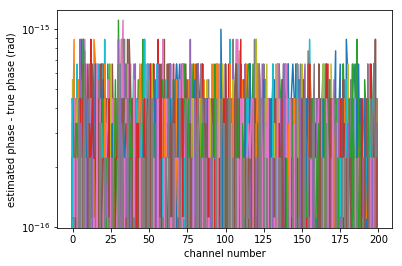

In [28]:
for i in range(gains.shape[1]):
    plt.plot(np.abs(gains[:,i])-np.abs(gainSolutionsPerfect[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.yscale('log')



In [29]:
testArray.applyGains(gains)
dCube=testArray.getVisCubeMatrixOrder()
testArray.correctGains(gains)
mCube=testArrayModel.getVisCubeMatrixOrder()
wCube=np.ones_like(mCube)
vF=np.empty((nAnt,nAnt),dtype=bool)
vF[:]=False
#niters,gainSolutions=calibrateChannelsParallel(dCube,mCube,wCube)
niters,gainSolutions=calibrateChannelsFlags(dCube,mCube,wCube*np.abs(mCube)**2.,aFlag,vF,ncycles=5,parallel=True)

#print niters



In [30]:
print np.array(niters).astype(int)

[[2862 2575 1193 1395  713]
 [2999 2698 1811 1487  998]
 [3150 2898 1991 1435  903]
 [3363 3119 1917 1628 1339]
 [3356 3204 1875 1817 1461]
 [3157 3199 2154 1814 1489]
 [3222 2909 1931 1652 1357]
 [3621 2876 1441  848  780]
 [3903 2942 2084 1672 1305]
 [4270 3127 2186 1828 1416]
 [4404 3090 1698 1595 1113]
 [4394 2924 2182 1636 1274]
 [4423 3042 2218 1573 1252]
 [4489 3197 2565 2003 1540]
 [4376 3230 2924 2308 1840]
 [4847 3537 3000 2356 1886]
 [4758 3353 2865 2223 1778]
 [4672 3351 3083 2516 2058]
 [4543 3279 3029 2504 2062]
 [4617 3346 3049 2549 2096]
 [4488 3263 2927 2456 2009]
 [4491 3167 2837 2343 1887]
 [4480 3225 2784 2213 1766]
 [4214 3422 2949 2204 1791]
 [4463 3839 3152 2370 1898]
 [5051 3944 3166 2503 2017]
 [5022 3738 3006 2119 1854]
 [4713 3715 3000 2160 1800]
 [4180 3426 2737 2172 1729]
 [3415 3192 2567 2132 1704]
 [3387 3018 2429 2030 1637]
 [3495 3042 2420 2019 1620]
 [3567 2917 2361 1963 1577]
 [3685 2854 2390 1974 1596]
 [3793 2827 2473 2024 1639]
 [3608 2836 2407 197

In [31]:
testArray.applyGains(gains)
dCube=testArray.getVisCubeMatrixOrder()
testArray.correctGains(gains)
mCube=testArrayModel.getVisCubeMatrixOrder()
wCube=np.ones_like(mCube)
for cnum in range(testArray.nChan):
    wCube[cnum,:,:]=wMat_t*np.abs(mCube[cnum,:,:])**2.
nitersWeighted,gainSolutionsWeighted=calibrateChannelsFlags(dCube,mCube,wCube,aFlag,vF,ncycles=10)

In [32]:
print np.array(nitersWeighted).astype(int)



[[10136  5558  5758 ...,  2768  2357  1861]
 [10367  5761  5998 ...,  2844  2478  1905]
 [10672  5970  6253 ...,  2932  2610  1958]
 ..., 
 [ 6040  4227  4453 ...,  3454  3289  3113]
 [ 6001  4219  4445 ...,  3445  3279  3102]
 [ 5923  4219  4440 ...,  3440  3273  3095]]


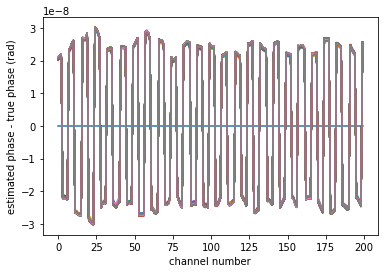

In [33]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutionsPerfect[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()


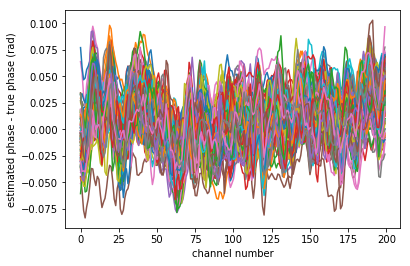

In [34]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutions[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()


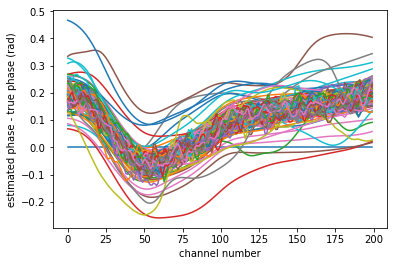

In [35]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutionsWeighted[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()


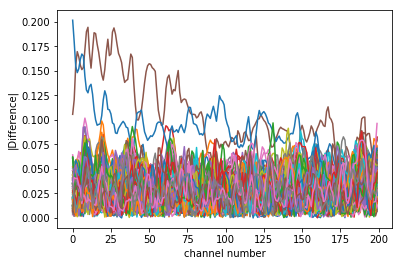

In [36]:
for i in range(gains.shape[1]):
    plt.plot(np.abs(gains[:,i]-gainSolutions[:,i]))

#plt.yscale('log')

plt.ylabel('|Difference|')
plt.xlabel('channel number')
plt.legend()


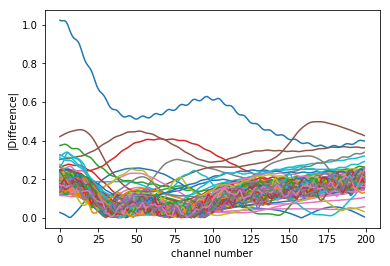

In [37]:
for i in range(gains.shape[1]):
    plt.plot(np.abs(gains[:,i]-gainSolutionsWeighted[:,i]))

#plt.yscale('log')

plt.ylabel('|Difference|')
plt.xlabel('channel number')
plt.legend()


In [38]:
print testArray.dAnt

4.0


In [39]:
nC=400
kperp_e,kpara_e,vGrid_true=getCalibrationGrid(testArray,testArrayModel,gains,gains,flagList,nCells=nC)
_,_,vGrid_w=getCalibrationGrid(testArray,testArrayModel,gains,gainSolutionsWeighted,flagList,nCells=nC)
_,_,vGrid_e=getCalibrationGrid(testArray,testArrayModel,gains,gainSolutions,flagList,nCells=nC)


/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


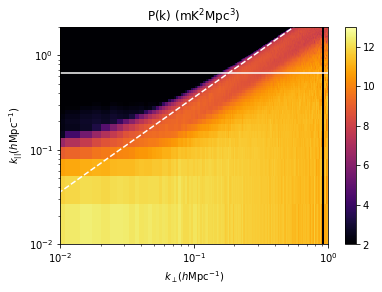

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


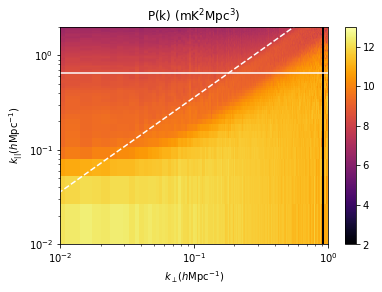

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10


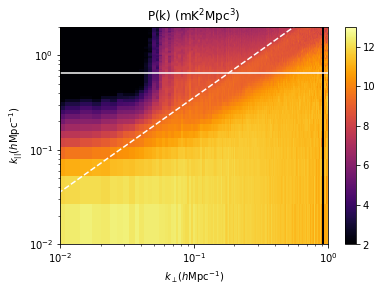

In [51]:
wVal=cosmology.wedge(cosmology.f2z(cFreq))
wLine=kperp_e*wVal
kperpG,kparG=np.meshgrid(kperp_e,kpara_e)

plt.pcolor(kperpG,kparG,np.log10(vGrid_true*(86e-3/1)**1.25),cmap='inferno',vmin=2,vmax=13)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq))/littleh,color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^3$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/mwa128_wedge_noErrors_largeAngleBS.png',bbox_inches='tight')
plt.show()

plt.pcolor(kperpG,kparG,np.log10(vGrid_e*(86e-3/1)**1.25),cmap='inferno',vmin=2,vmax=13)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq))/littleh,color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^3$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/mwa128_wedge_srcErrors_largeAngleBS.png',bbox_inches='tight')
plt.show()


plt.pcolor(kperpG,kparG,np.log10(vGrid_w*(86e-3/1)**1.25),cmap='inferno',vmin=2,vmax=13)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq))/littleh,color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^3$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/mwa128_wedge_weightedErrors_largeAngleBS.png',bbox_inches='tight')
plt.show()


/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


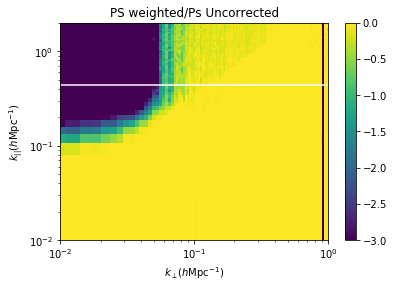

In [41]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_w/vGrid_e),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

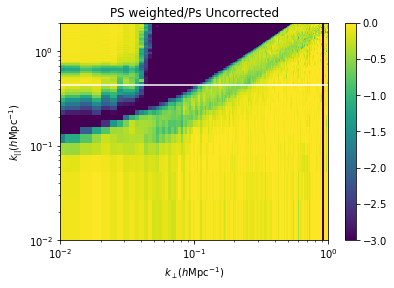

In [42]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_true/vGrid_w),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/PS')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

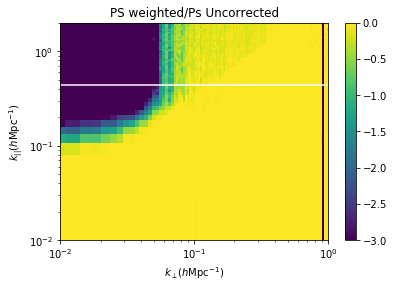

In [43]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_w/vGrid_e),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

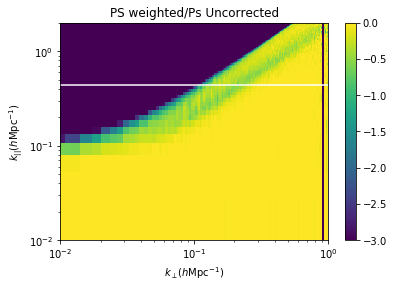

In [44]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_true/vGrid_e),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

In [45]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_e/vGrid_unCorrect),vmin=-10,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-2,2e0)
plt.xlim(5e-2,1e0)

NameError: name 'vGrid_unCorrect' is not defined

In [ ]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_e/vGrid_w),vmin=-2,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-2,2e0)
plt.xlim(5e-2,1e0)

In [ ]:
plt.pcolor(kperpG,kparG,(vGrid_w/vGrid_e),vmin=1,vmax=10)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-2,2e0)
plt.xlim(5e-2,1e0)

In [ ]:
275/sum(np.abs(weightsMatrix.flatten())/np.abs(weightsMatrix.flatten()).max())

In [ ]:
nf=testArray.nChan
window=signal.blackmanharris(nf)
window/=np.sqrt(np.mean(window**2.))
for i in range(gains.shape[1]):
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]-gainSolutions[:,i])))[:nf/2])
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]-gainSolutionsWeighted[:,i])))[:nf/2],ls='--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-2,1e0)
plt.ylim(1e-8,1e1)
#plt.ylim(1e-1,1e1)
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')

In [ ]:
for i in range(8,9):
    plt.plot(np.abs(gains[:,i]/gainSolutions[:,i])**-1,ls='-')
    plt.plot(np.abs(gains[:,i]/gainSolutionsWeighted[:,i])**-1,ls='-')
    plt.plot(np.abs(gains[:,i]),lw=2,color='k')

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.show()






In [ ]:
for i in range(1):
    plt.plot(kpara_e,np.abs((fft.ifft(window*(gains[:,i]/gainSolutions[:,i])**-1)))[:nf/2],ls='--')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('kpara')
plt.legend()
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')




In [ ]:
for i in range(1):
    plt.plot(kpara_e,np.abs((fft.ifft(window*(gains[:,i]/gainSolutionsWeighted[:,i])**-1)))[:nf/2],ls='--')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('kpara')
plt.legend()
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')





In [ ]:
nf=testArray.nChan
window=signal.blackmanharris(nf)
window/=np.sqrt(np.mean(window**2.))
for i in range(gains.shape[1]):
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]/gainSolutions[:,i])))[:nf/2])
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]/gainSolutionsWeighted[:,i])))[:nf/2],ls='--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-2,1e0)
plt.ylim(1e-5,1e-3)
#plt.ylim(1e-1,1e1)
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')